# Mapping strava routes

Point the notebook to the folder where the gpx are sitting

In [1]:
my_folder = '/Users/ushhamilton/Documents/40_Map_Data/Cycle Touring/2022/gpx/'

In [15]:
import os
import pandas as pd
import numpy as np
import gpxpy as gp
from gpxpy.geo import distance
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
data_files = [] # populate this list if you want to specify only certain files in the folder

if len(data_files) == 0:
    data_files = os.listdir(my_folder)

data_files

['Into_Italy.gpx',
 'Dolomite_ride.gpx',
 'The_easy_day.gpx',
 'Dunzo_hunzo.gpx',
 'To_the_train.gpx',
 'A_pass_for_breakfast_and_lunch.gpx',
 'Legs_cooked_to_perfection.gpx']

In [4]:
gpx_files = list()
for file in data_files:
    gpx_file = open(my_folder + '/' + file, 'r')
    gpx_files.append(gp.parse(gpx_file))

In [5]:
temp_data = list()
for gpx in gpx_files:
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                temp_data.append([point.time, point.latitude, point.longitude, point.elevation])

In [6]:
total_data = pd.DataFrame(temp_data, columns=['time', 'lat', 'lon', 'ele'])
total_data['date'] = total_data['time'].dt.date
total_data = total_data.sort_values(by=['time'])

# Calculate distance
temp_dist = [0]
temp_ele = [0]
for (ix1, row1), (ix2, row2) in zip(total_data.iloc[:-1].iterrows(), total_data.iloc[1:].iterrows()):
    temp_dist.append(distance(
                        latitude_1=row1['lat'],
                        longitude_1=row1['lon'], 
                        elevation_1=None,
                        latitude_2=row2['lat'],
                        longitude_2=row2['lon'], 
                        elevation_2=None))
    temp_ele.append(row2['ele'] - row1['ele'])

total_data['dist'] = temp_dist
total_data['ele_delta'] = temp_ele
total_data['CumDist'] = total_data['dist'].cumsum()

total_data.head()

,time,lat,lon,ele,date,dist,ele_delta,CumDist
33816,2022-07-10 09:03:59+00:00,47.592552,12.180832,491.1,2022-07-10,0.000000,0.0,0.000000
33817,2022-07-10 09:04:00+00:00,47.592548,12.180844,491.2,2022-07-10,1.004920,0.1,1.004920
33818,2022-07-10 09:04:01+00:00,47.592545,12.180855,491.2,2022-07-10,0.890781,0.0,1.895702
33819,2022-07-10 09:04:02+00:00,47.592544,12.180858,491.2,2022-07-10,0.251230,0.0,2.146932
33820,2022-07-10 09:04:03+00:00,47.592542,12.180862,491.2,2022-07-10,0.373825,0.0,2.520757


We need to filter these points as there are too many to plot, and we only need a point every 100 or so metres

In [7]:
def filter_points(df, gaps=100):
    # Defualt to taking a point every 100 metres
    total_data['CumDist_div'] = (total_data['CumDist'] / gaps).astype(int)
    filtered = total_data[total_data['CumDist_div'] != total_data['CumDist_div'].shift(1)]
    return filtered.drop('CumDist_div', axis=1)

filtered_data = filter_points(total_data)

In [177]:
cmap = mpl.colormaps['Purples']
filtered_data['perc_ele'] = filtered_data['ele'] / filtered_data['ele'].max()


In [178]:
lat, lon, ele = filtered_data['lat'].to_list(), filtered_data['lon'].to_list(), filtered_data['perc_ele'].to_list()
segs = np.array([[(lon[i], lat[i]), (lon[i+1], lat[i+1])] for i in range(len(lat)-1)])

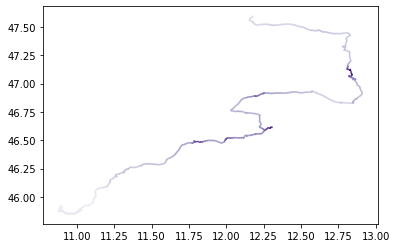

In [199]:
cols = mpl.collections.LineCollection(segs, cmap=cmap, norm=mpl.colors.Normalize(-0.1, 1))
cols.set_array(ele[:-1])

fig, ax = plt.subplots()
ax.add_collection(cols)
ax.autoscale_view()
# ax.col

plt.show()